# Historic Spotify Chart Analysis
In this notebook, we will analyze the historic Spotify charts to determine recurring christmas songs and artists. The data has been pulled from [Spotifycharts](https://spotifycharts.com/home/) Top 200 Weekly Playlist. Since the charts API has been deprecated and scraping is against their Terms of Service, we"ll be using the [historic Spotify charts dataset from Kaggle](https://www.kaggle.com/bartomiejczyewski/spotify-top-200-weekly-global-20172021).

First let"s load the data into a pandas dataframe to do some basic data cleanup.

In [236]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
plt.style.use("dark_background")

def read_historic_data(filepath):
  df_h = pd.read_csv(filepath)

  # load the date strings as datetime objects
  df_h["date"] = pd.to_datetime(df_h["Week"])
  df_h = df_h.set_index("date")
  df_h.drop(["Week"], axis=1, inplace=True)

  # drop other dataframe columns that aren"t of interest
  df_h.drop(["Explicit", "Track_Number_on_Album", "Artist_Followers", "Duration_MS", "Track_Number_on_Album", "Link", "Album_Name"], axis=1, inplace=True)

  df_h["Artist"] = df_h["Artist"].astype("string")
  df_h["Track"] = df_h["Track"].astype("string").str.lower()

  # convert the Artist_Genres column to lists
  df_h["Artist_Genres"] = df_h["Artist_Genres"].apply(eval)
  return df_h

df = read_historic_data("archive/historicCharts.csv")
df.head()

genre_popularity = df["Artist_Genres"].explode().value_counts().to_frame().reset_index().sort_values(by="Artist_Genres", ascending=False)

genres_by_month = df.groupby([df.index.month]).apply(lambda x: x.sum())["Artist_Genres"].explode()
# now we need to count the duplicate rows and plot them over time to see trends in genres.
# relative_popularity["relative"] = relative_popularity.Artist_Genres.div(relative_popularity.Artist_Genres_total, fill_value=0)
  


The most frequently played christmas songs, determined by how often they appear in the charts around christmas. By using this method, one hit wonders and songs that just happen to be trending in december are not included (as often). We then filter out all the songs that appear in the charts during other times of the year, to eliminate some remaining outliers. 

,Streams,place
Track,,
all i want for christmas is you,632224394,0
last christmas,481849383,1
santa tell me,359069064,2
it's beginning to look a lot like christmas,328704829,3
jingle bell rock,296546723,4


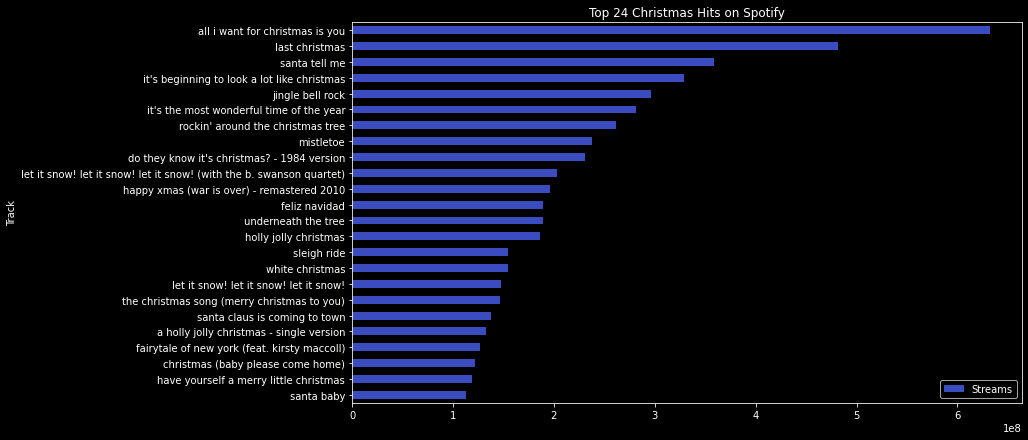

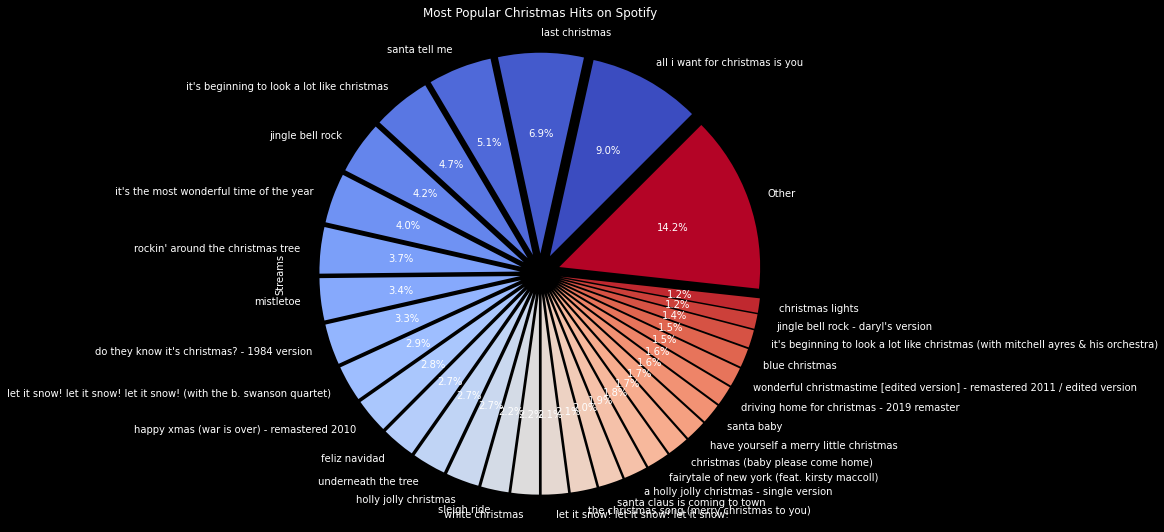

In [249]:
# filter by month (November and December seem to be the time for christmas songs)
songs_to_evaluate = 200
december_hits = df[df.index.month == 12]["Track"].value_counts().index[:songs_to_evaluate].values

# christmas hits are only played around christmas, so we can filter out all the songs that are also played in the other months
non_christmas_months = (df.index.month >= 2 ) & (df.index.month <= 9)
#these are all wrongly identified christmas hits
non_christmas_hits = df[non_christmas_months & df["Track"].isin(december_hits)]

christmas_hits_df = df[df["Track"].isin(december_hits) & ~df["Track"].isin(non_christmas_hits["Track"])]
# Sorted by the total number of streams (while in the charts)
most_popular_hits = christmas_hits_df.groupby("Track").agg({"Streams": "sum"}).sort_values(by="Streams", ascending=False)

most_popular_hits[:24].sort_values(by="Streams", ascending=True).plot(kind="barh", figsize=(12,7), 
                      title="Top 24 Christmas Hits on Spotify", colormap="coolwarm")


# The Pie chart of most popular christmas songs
top_30 = most_popular_hits[:30].copy()
others = pd.DataFrame(data = {"Streams" : [most_popular_hits["Streams"][30:].sum()]}, index = ["Other"])
pd.concat([top_30, others]).plot(kind="pie", figsize=(9,10), y="Streams", legend=False, 
                      title="Most Popular Christmas Hits on Spotify",  colormap="coolwarm", 
                      autopct="%.1f%%", explode=(.1,)*(top_30.Streams.count()+1),startangle=45)

# The table of most popular christmas songs
most_popular_hits['place'] = np.arange(len(most_popular_hits))
most_popular_hits.head()

Chart wordcloud


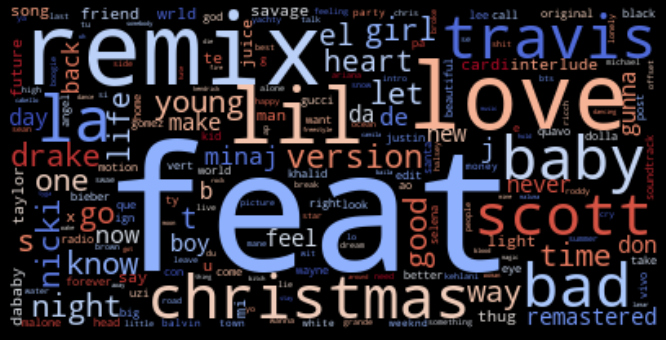

Christmas wordcloud


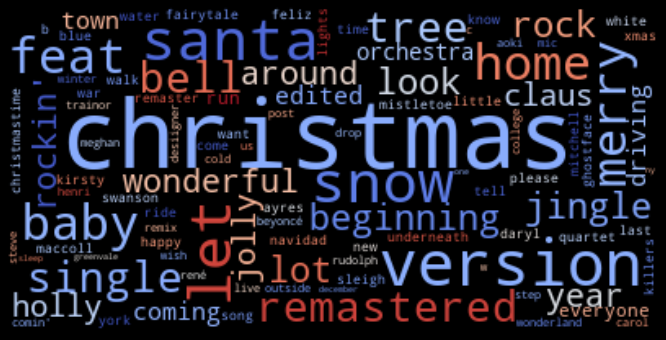

In [238]:
import re
from wordcloud import WordCloud

chartcloud = WordCloud(colormap="coolwarm", collocations=False, background_color="black")

print("Chart wordcloud")	
# The Wordcloud of all the words in the charts
all_char_songs = df.drop_duplicates(subset=["Track"])["Track"]
all_char_songs = all_char_songs[~all_char_songs.isnull() ]
chartcloud.generate(" ".join(all_char_songs.values))

plt.figure(figsize=(12, 6))
plt.imshow(chartcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

print("Christmas wordcloud")	

bag_of_words = " ".join(most_popular_hits.index.values)
chartcloud.generate(bag_of_words)

plt.figure(figsize=(12, 6))
plt.imshow(chartcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Now let"s see how these songs rank throughout the years
First we have to restructure the dataframe to be indexed by date (all weeks from start to finish) and fill the cells with Streams. The names of the christmas hits will be used to adress the columns. By doing this, we can easily plot and compare the songs across years.

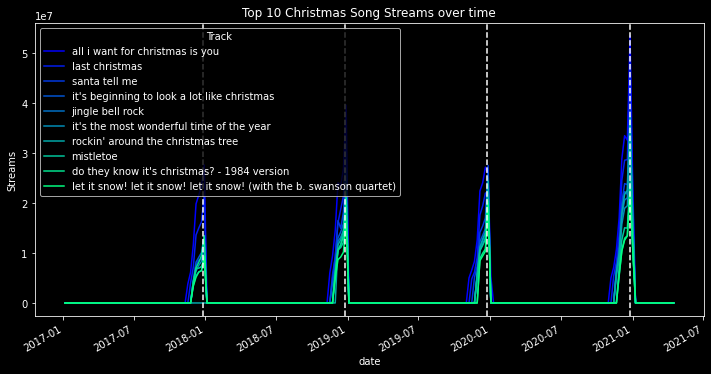

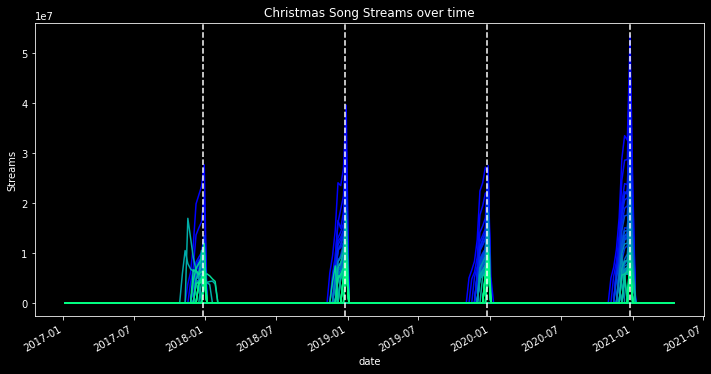

In [246]:
def draw_christmas_vlines(plot_object):
  for i in range(2017,2021):
    plot_object.axvline(x=datetime.datetime(i, 12, 25), color="white", linestyle="--")

def plot_christmas_streams(input_df, songs_to_plot, inp_title):
  timeline = pd.date_range(start=input_df.index[0], end=input_df.index[-1], freq="W")

  # Figuring out this pivot took me way too long...
  christmas_charts = input_df.pivot_table(columns="Track", values="Streams", index="date", fill_value=0)[songs_to_plot]

  # To plot all the lines, do this:
  timeline_plot = christmas_charts.plot(kind="line", figsize=(12,6), title=inp_title, 
                                        colormap="winter", ylabel="Streams", 
                                        legend=songs_to_plot.size<24)
  draw_christmas_vlines(timeline_plot)

plot_christmas_streams(df, most_popular_hits.index[:10], "Top 10 Christmas Song Streams over time")
plot_christmas_streams(df, most_popular_hits.index,"Christmas Song Streams over time")

## The scoring function
Now that we have a rough idea of how christmas hits rank over time, we can develop a scoring function, that analyzes the current charts and returns the current mood. 

The Christmas song multiplier function determines if the song is christmas themed based on the track name. If the song is certainly christmas themed, the multiplier is 1, otherwise it"s 0. The function is then multiplied by the number of streams to determine the weighted stream count. To determine that weeks christmas score, we sum the weighted stream counts for all the trending songs and divide by the total number of streams, which is more or less equivalent to the percentage of christmas themed streams of that week. Since we are dividing by the total number of streams, the scoring function is time independent and can be used for daily, weekly, or monthly analysis interchangably.

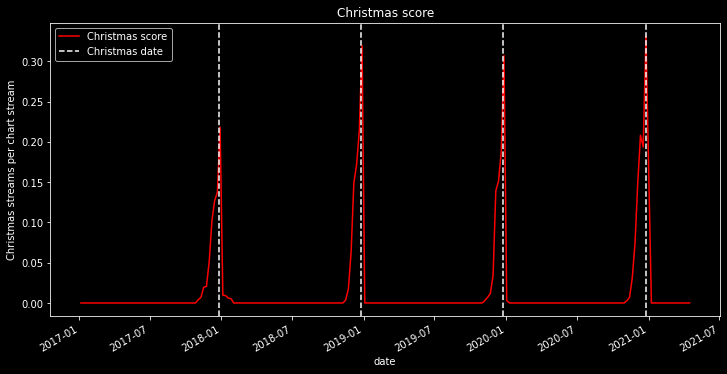

In [240]:
def christmas_score(row):
  return row.sum()

def is_known_christmas_song(song_titles):
  return song_titles.isin(most_popular_hits.index).astype(float)

def song_multipliers(song_titles):
  def title_to_multiplier(title):
    # percentage of words that are classified as christmas themed
    score = 0
    title_words = title.split()
    for word in title_words:
      if word in wordcloud.words_:
        score += wordcloud.words_[word]*2

    score /= len(title_words)
    return score

  return song_titles.to_frame()["Track"].apply(title_to_multiplier)


def df_to_score(inputdf):
  column_df = inputdf.pivot_table(columns="Track", values="Streams", index="date", fill_value=0)
  weighted_column_df = column_df.mul(is_known_christmas_song(column_df.columns), axis=1).apply(christmas_score, axis=1)
  total_streams_df = column_df.apply(lambda x: x.sum(), axis=1)
  return weighted_column_df.div(total_streams_df)

final_score_df = df_to_score(df)

cscore_plt = final_score_df.plot(kind="line", figsize=(12,6), color="red",)
draw_christmas_vlines(cscore_plt)
cscore_plt.set_title("Christmas score")
cscore_plt.set_ylabel("Christmas streams per chart stream")
cscore_plt.legend(["Christmas score", "Christmas date"],loc="upper left")

# The top scoring christmas songs by track title
# song_multipliers(column_df.columns).sort_values(ascending=False).head(15)

# Creating a model
We"ll use a simple exponential function to model the trends around christmas. Since there christmas songs are only trending in the last few weeks of the year, we"ll just model that segment. Without any trending christmas songs, we can"t really do any predictions anyway. 

Text(0.5, 1.0, 'Characteristic increase in christmas streams at the end of the year')

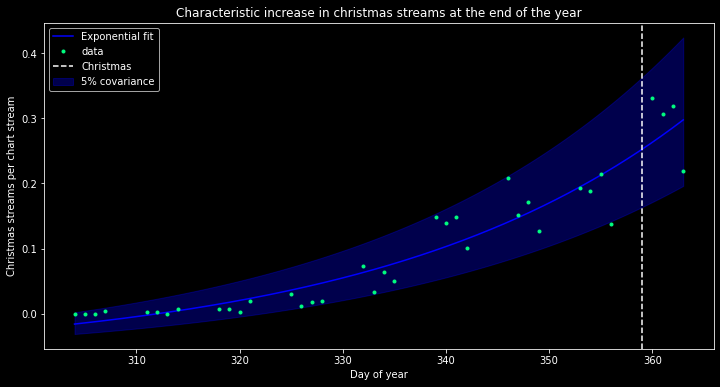

In [241]:
from scipy.optimize import curve_fit

# choose the input and output variables
data_for_model = final_score_df.dropna()[final_score_df.index.dayofyear > 300]
x = np.asarray(data_for_model.index.dayofyear, float)
y = data_for_model.values

smooth_x = np.linspace(x.min(), x.max(), 1000)

def exponential(x, a, b, c):
    return a*np.exp(b*x) + c

fit_parameters, cov = curve_fit(exponential, x, y, p0=[.2, .05, 310])
fit_err = np.sqrt(np.diag(cov))
fit_err *= .05 # really high uncertainty, so we"ll only show a 5% std deviation

colors = [plt.cm.winter(x) for x in np.linspace(0, 1,2)]


plt.figure(figsize=(12, 6))
plt.plot(smooth_x, exponential(smooth_x, *fit_parameters), label="Exponential fit", color=colors[0])
plt.plot(x, y, ".", label="data", color=colors[1])
plt.xlabel("Day of year")
plt.ylabel("Christmas streams per chart stream")
plt.fill_between(x=smooth_x, 
  y1=exponential(smooth_x, *(fit_parameters + fit_err)), 
  y2=exponential(smooth_x, *(fit_parameters - fit_err)), 
  alpha=0.3, label="5% covariance", color=colors[0])

plt.axvline(x=datetime.datetime(2021, 12, 25).timetuple().tm_yday, linestyle="--", label="Christmas")
plt.legend()
plt.title("Characteristic increase in christmas streams at the end of the year")

## Predicting the future

Now that we have a mathematical model, we can find the roots of the polynomial to determine where we are in time (the x axis). Negative values mean that we before christmas, positive values mean we are in the new year. Now we just have to convert weeks to days and subtract them from the current date to get the most probable christmas date.

In [242]:
def day_from_score(current_score, min_time=300, max_time=365):
  min_val = 0
  max_val = exponential(max_time, *fit_parameters)
  if(current_score <= min_val):
    return 0 # or maybe rater np.nan to indicate no data?
  elif(current_score >= max_val):
    return max_time
  a,b,c = fit_parameters
  return np.log(current_score/a - c)/b


import datetime
print(datetime.date.today().timetuple().tm_yday, day_from_score(0.08))


329 317.017633274463


The same can be done using current chart data, since we are using the relative stream count, it doesn"t even matter if we are using daily, weekly, or monthly data. I am using the old [Spotifycharts](https://spotifycharts.com/regional/global/weekly/latest) API, which is deprecated, but the data is still available. Just download the csv file for the date you"re interested in and place it in the `archive` folder before running the following code block.

In [243]:
# The daily CSV data is structured differently. 
# This function will bring it into the same format we used throughout the notebook.
def read_current_data(filepath):
  df_c = pd.read_csv(filepath,skiprows = 1)
  date_string = re.search(r"\d{4}-\d{2}-\d{2}", filepath).group(0)
  # load the date strings as datetime objects
  df_c["date"] = pd.to_datetime(date_string)
  df_c = df_c.set_index("date")

  # drop other dataframe columns that aren"t of interest
  df_c.drop(["URL"], axis=1, inplace=True)
  df_c.rename(columns={"Track Name": "Track"}, inplace=True)

  df_c["Artist"] = df_c["Artist"].astype("string")
  df_c["Track"] = df_c["Track"].astype("string").str.lower()
  return df_c

import os

path = os.path.realpath(os.getcwd()+"/archive")
results_df = pd.DataFrame(columns=["day", "predicted day", "prediction error"])
files= list(os.walk(path))[0][2]
for f in files:
  if(re.match(r"regional-global-daily-",f)):
    file_df = read_current_data(path+"//"+f)
    predicted_day = day_from_score(df_to_score(file_df)[0])
    real_day = file_df.index[0].dayofyear
    results_df = results_df.append({"day": real_day, 
                                    "predicted day": predicted_day, 
                                    "prediction error": real_day - predicted_day}, ignore_index=True)
    # print("day: {:0.1f} \t predicted day: {:0.1f} \t prediction error: {:0.1f}\t ".format(real_day, predicted_day, real_day-predicted_day))
results_df


,day,predicted day,prediction error
0,347.0,347.426088,-0.426088
1,348.0,350.377384,-2.377384
2,349.0,339.169067,9.830933
3,350.0,340.515345,9.484655
4,351.0,342.640869,8.359131
5,352.0,346.315621,5.684379
6,353.0,349.318262,3.681738
7,354.0,354.441331,-0.441331
8,355.0,355.943501,-0.943501
9,356.0,351.018691,4.981309
